# Projet Apprentissage Supervisée: Change detection in bi-temporal remote sensing image 

### Clément Guigon - Ophélia Urbing - Etienne Bardet

#### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TVF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import *
from network import *
from tqdm import tqdm
from utils import *
from skimage import exposure
from torcheval.metrics.functional import binary_f1_score

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### Dataset

In [3]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        #repeat the data 5 times to have more data
        self.data = pd.read_csv(csv_file).sample(frac=30, replace=True)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def random_flip(self, img1,img2,cm, chance=0.5):
        if (np.random.randint(0,1)> chance):
            img1 = TVF.hflip(img1)
            img2 = TVF.hflip(img2)
            cm = TVF.hflip(cm)

        if (np.random.randint(0,1)> chance):
            img1 = TVF.vflip(img1)
            img2 = TVF.vflip(img2)
            cm = TVF.vflip(cm)

        return img1, img2, cm

    def apply_hist_dynamic(self, source, target):
        for i in range(3):
            mean1_cn = torch.mean(source[i,:,:])
            std1_cn = torch.std(source[i,:,:])
            mean2_cn = torch.mean(target[i,:,:])
            std2_cn = torch.std(target[i,:,:])
            target[i,:,:] = ((target[i,:,:] - mean2_cn) / std2_cn)*std1_cn + mean1_cn
        return target

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])

        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)
        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        crop1, crop2, cropcm = self.random_flip(crop1[:,:,:], crop2[:,:,:], cropcm[:,:,:])
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()/255
        #apply the same transformation to all images as batch dimension
        img2Tensor = self.apply_hist_dynamic(img1Tensor, img2Tensor)
        img2Tensor = torch.clamp(img2Tensor, 0, 1)
        img1Tensor, img2Tensor = torch.Tensor(exposure.equalize_adapthist(img1Tensor.permute(1,2,0).numpy())).permute(2,0,1), torch.Tensor(exposure.equalize_adapthist(img2Tensor.permute(1,2,0).numpy())).permute(2,0,1)
        return img1Tensor, img2Tensor, cmTensor
        

#### DataLoader class for our change detection dataset

In [4]:
#Simple DataLoader class for our change detection dataset
batch_size = 32

weights = class_weights("data.csv")
weights = torch.tensor(weights[0]/weights[1]).to(device)

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)


C:\Users\arceo\AppData\Local\Temp\ipykernel_1076\2502179640.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights[0]/weights[1]).to(device)


#### Function to display a batch of images

In [5]:
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()
#a = next(iter(train_loader))
#show_batch(a)

#### Model

In [6]:
n_epoch = 30
learning_rate = 0.0005
model = ChangeDetectUnet(in_chan=9).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []
train_precision, val_precision = [], []
model = model.to(device)
best_loss =1000

for epoch in range(n_epoch):
    model.train()
    loss_cumu, f1 = 0,0

    for img1, img2, cm in tqdm(train_loader, ascii=" >="):
        img1, img2, cm = img1.to(device), img2.to(device), cm.to(device)

        # Forward pass
        y_pred = model(img1, img2)
        pred_binary = torch.ceil(torch.threshold(y_pred, 0.1, 0))
        loss = loss_fn(y_pred, cm)  # Supervision profonde
        loss_cumu += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Précision
        ground_truth_flat = cm.flatten()
        predictions_flat = pred_binary.flatten() 

        f1 += binary_f1_score(ground_truth_flat, predictions_flat)  
    train_loss.append(loss_cumu / len(train_loader))
    train_precision.append(f1/len(train_loader))

    # Validation
    model.eval()
    loss_cumu, f1 = 0, 0
    with torch.no_grad():
        for img1, img2, cm in val_loader:
            img1, img2, cm = img1.to(device), img2.to(device), cm.to(device)
                        
            y_pred = model(img1, img2)
            pred_binary = torch.ceil(torch.threshold(y_pred, 0.1, 0))
            loss = loss_fn(y_pred, cm)
            loss_cumu += loss.item()
  
            ground_truth_flat = cm.flatten()
            predictions_flat = pred_binary.flatten()
            f1 += binary_f1_score(ground_truth_flat, predictions_flat)  
            if loss_cumu / len(val_loader) < best_loss:
                best_loss = loss_cumu / len(val_loader)
                torch.save(model.state_dict(), "best_model.pt")
        val_loss.append(loss_cumu / len(val_loader))
        val_precision.append(f1/len(val_loader))
    
    print(f"Epoch {epoch+1} : Training, loss: {train_loss[-1]:.4f}, precision: {train_precision[-1]:.4f} | Validation, loss: {val_loss[-1]:.4f}, precision: {val_precision[-1]:.7f}")

100%|==========| 18/18 [00:45<00:00,  2.52s/it]


Epoch 1 : Training, loss: 0.9567, precision: 0.0532 | Validation, loss: 0.9813, precision: 0.0689868


100%|==========| 18/18 [00:47<00:00,  2.66s/it]


Epoch 2 : Training, loss: 0.9120, precision: 0.0559 | Validation, loss: 0.9267, precision: 0.0629014


100%|==========| 18/18 [00:57<00:00,  3.21s/it]


Epoch 3 : Training, loss: 0.9013, precision: 0.0548 | Validation, loss: 0.9117, precision: 0.0591274


100%|==========| 18/18 [00:45<00:00,  2.54s/it]


Epoch 4 : Training, loss: 0.8955, precision: 0.0610 | Validation, loss: 0.9199, precision: 0.0703195


100%|==========| 18/18 [00:41<00:00,  2.29s/it]


Epoch 5 : Training, loss: 0.8832, precision: 0.0613 | Validation, loss: 0.8972, precision: 0.0637961


100%|==========| 18/18 [00:46<00:00,  2.60s/it]


Epoch 6 : Training, loss: 0.8730, precision: 0.0617 | Validation, loss: 0.8866, precision: 0.0648661


100%|==========| 18/18 [00:40<00:00,  2.23s/it]


Epoch 7 : Training, loss: 0.8608, precision: 0.0549 | Validation, loss: 0.8874, precision: 0.0613739


100%|==========| 18/18 [00:40<00:00,  2.27s/it]


Epoch 8 : Training, loss: 0.8546, precision: 0.0546 | Validation, loss: 0.8690, precision: 0.0607472


100%|==========| 18/18 [00:42<00:00,  2.36s/it]


Epoch 9 : Training, loss: 0.8450, precision: 0.0550 | Validation, loss: 0.8846, precision: 0.0666565


100%|==========| 18/18 [00:42<00:00,  2.34s/it]


Epoch 10 : Training, loss: 0.8354, precision: 0.0537 | Validation, loss: 0.8669, precision: 0.0698105


100%|==========| 18/18 [00:42<00:00,  2.34s/it]


Epoch 11 : Training, loss: 0.8360, precision: 0.0644 | Validation, loss: 0.8654, precision: 0.1081033


100%|==========| 18/18 [00:40<00:00,  2.25s/it]


Epoch 12 : Training, loss: 0.8276, precision: 0.0727 | Validation, loss: 0.8837, precision: 0.0821569


100%|==========| 18/18 [00:44<00:00,  2.47s/it]


Epoch 13 : Training, loss: 0.8182, precision: 0.0946 | Validation, loss: 0.8436, precision: 0.1365913


100%|==========| 18/18 [00:35<00:00,  1.96s/it]


Epoch 14 : Training, loss: 0.8116, precision: 0.1278 | Validation, loss: 0.8526, precision: 0.2116107


100%|==========| 18/18 [00:36<00:00,  2.04s/it]


Epoch 15 : Training, loss: 0.8125, precision: 0.2106 | Validation, loss: 0.8589, precision: 0.2303225


100%|==========| 18/18 [00:49<00:00,  2.78s/it]


Epoch 16 : Training, loss: 0.8122, precision: 0.2948 | Validation, loss: 0.8519, precision: 0.2490540


100%|==========| 18/18 [00:50<00:00,  2.78s/it]


Epoch 17 : Training, loss: 0.8073, precision: 0.3362 | Validation, loss: 0.8321, precision: 0.2966036


100%|==========| 18/18 [00:51<00:00,  2.85s/it]


Epoch 18 : Training, loss: 0.7938, precision: 0.3614 | Validation, loss: 0.8418, precision: 0.3244607


100%|==========| 18/18 [00:45<00:00,  2.51s/it]


Epoch 19 : Training, loss: 0.7969, precision: 0.4285 | Validation, loss: 0.8249, precision: 0.3360472


100%|==========| 18/18 [00:41<00:00,  2.31s/it]


Epoch 20 : Training, loss: 0.7992, precision: 0.4458 | Validation, loss: 0.8270, precision: 0.3143207


100%|==========| 18/18 [00:41<00:00,  2.33s/it]


Epoch 21 : Training, loss: 0.7883, precision: 0.4547 | Validation, loss: 0.8323, precision: 0.2884315


100%|==========| 18/18 [00:43<00:00,  2.40s/it]


Epoch 22 : Training, loss: 0.7917, precision: 0.4567 | Validation, loss: 0.8218, precision: 0.3290820


100%|==========| 18/18 [00:43<00:00,  2.44s/it]


Epoch 23 : Training, loss: 0.7846, precision: 0.4555 | Validation, loss: 0.8304, precision: 0.3291820


100%|==========| 18/18 [00:40<00:00,  2.25s/it]


Epoch 24 : Training, loss: 0.7837, precision: 0.5012 | Validation, loss: 0.8038, precision: 0.3298393


100%|==========| 18/18 [00:38<00:00,  2.15s/it]


Epoch 25 : Training, loss: 0.7811, precision: 0.5252 | Validation, loss: 0.8240, precision: 0.2871681


100%|==========| 18/18 [00:38<00:00,  2.14s/it]


Epoch 26 : Training, loss: 0.7829, precision: 0.5258 | Validation, loss: 0.8107, precision: 0.3710837


100%|==========| 18/18 [00:39<00:00,  2.18s/it]


Epoch 27 : Training, loss: 0.7871, precision: 0.5046 | Validation, loss: 0.8228, precision: 0.3753112


100%|==========| 18/18 [00:39<00:00,  2.17s/it]


Epoch 28 : Training, loss: 0.7858, precision: 0.5161 | Validation, loss: 0.8178, precision: 0.2679425


100%|==========| 18/18 [00:43<00:00,  2.44s/it]


Epoch 29 : Training, loss: 0.7857, precision: 0.5510 | Validation, loss: 0.8034, precision: 0.3083339


100%|==========| 18/18 [00:39<00:00,  2.20s/it]


Epoch 30 : Training, loss: 0.7796, precision: 0.5413 | Validation, loss: 0.8115, precision: 0.3726042


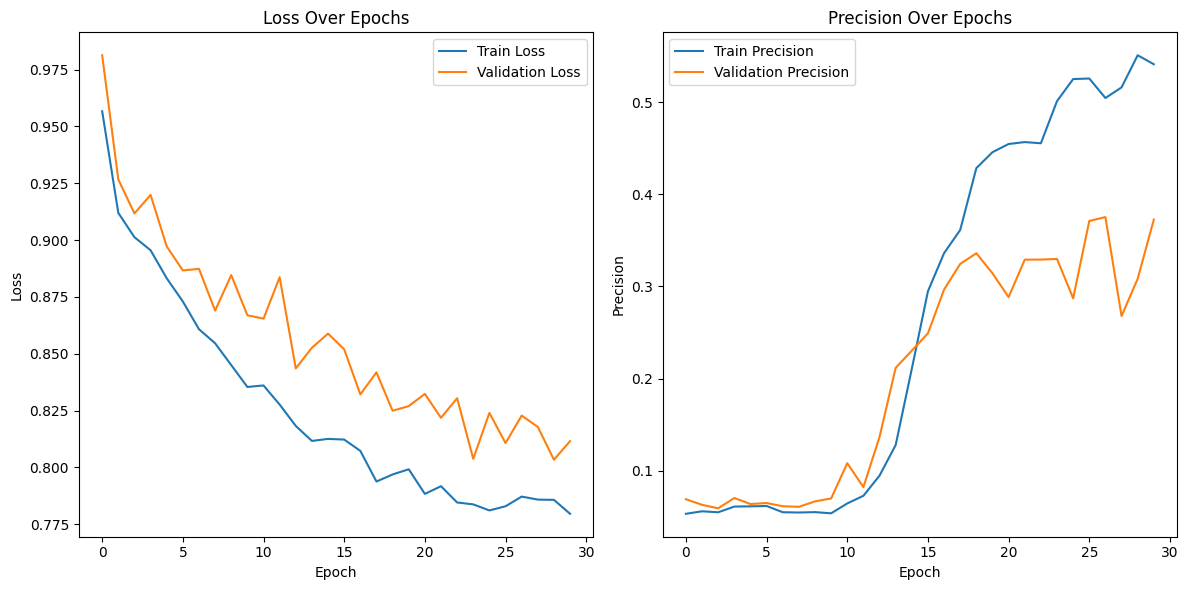

In [11]:

# Affichage des courbes
plt.figure(figsize=(12, 6))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
 
# Courbes de précision
plt.subplot(1, 2, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

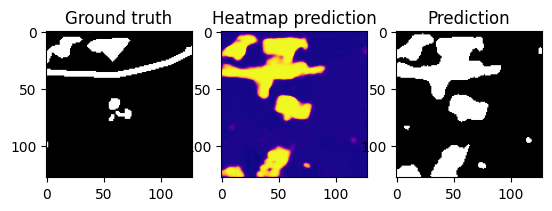

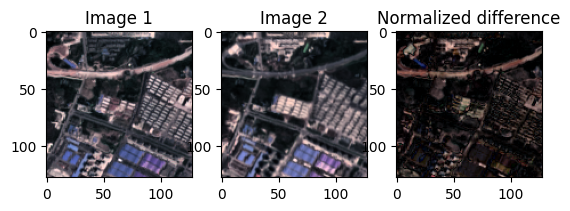

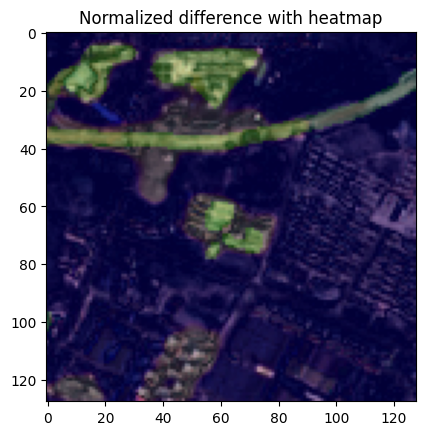

In [25]:
model.cpu()
model.eval()

im1,im2,cm = next(iter(val_loader))

cm_pred = model(im1,im2)#, with_attn=False)
cm_pred_bin = torch.ceil(torch.threshold(cm_pred.detach(), 0.1, 0))

### Affichage des masques
plt.figure()
plt.subplot(1,3,1)
plt.imshow(cm[0].permute(1,2,0), cmap='gray')
plt.title("Ground truth")
plt.subplot(1,3,2)
plt.imshow(cm_pred.detach()[0].permute(1,2,0), cmap='plasma')
plt.title("Heatmap prediction")
plt.subplot(1,3,3)
plt.imshow(cm_pred_bin.detach()[0].permute(1,2,0), cmap='gray')
plt.title("Prediction")
plt.show()

### Affichage des images bi-temporelles
dif = im1[0]-im2[0]
dif_norm = torch.clamp((torch.abs(dif)-torch.mean(dif)),0,1)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(im1[0].permute(1,2,0))
plt.title("Image 1")
plt.subplot(1,3,2)
plt.imshow(im2[0].permute(1,2,0))
plt.title("Image 2")
plt.subplot(1,3,3)
plt.imshow(dif_norm.permute(1,2,0))
plt.title("Normalized difference")
plt.figure()
plt.imshow(dif_norm.permute(1,2,0))
plt.imshow(cm_pred.detach()[0].permute(1,2,0), cmap='plasma', alpha=0.15)
plt.imshow(cm[0].permute(1,2,0), cmap='winter', alpha=0.15)
plt.title("Normalized difference with heatmap")

plt.show()

# Notes
U-Net peut être utile

# Soutenance
 - Explication du problème et comment le transcrire
 - Pré-traitement des données
 - Architecture du réseau
 - Présentation des résultats
 
# Rendu 
 - Slides de présentation (10 minutes+ 10 min de questions)
 - Notebook avec le code

À rendre en séance. 